# Three Component Data Processing Basics
## Creating Seismogram Objects
MsPASS considers two data types to be atomic seismic data.  What we call a *TimeSeries* is a single channel of data.  An example familiar to seismologists is that in the SEED format the union of four "station codes", net, sta, chan, and loc, define a unique channel of data from some instrument on the planet.  In all seismic data processing we usually cut out sections of data as a chunk to be dealt with as a single entity.  There are some algorithms where the model of a single channel of data is meaningless or useless.  Data recorded by a three-component seismic station is a case in point;  the components have a fundamental relationship that for some applications make them indivisible.  Two examples most seismologists will be familiar with particle motion measurements and conventional receiver functions.   Both require an input of three-component data to make any sense.   For this reason we distinguish a different atomic object we call a *Seismogram* to define data that is by definition a three-component set of recordings.

The problem of assembling three-component data from raw data is not at all trivial. Today most data loggers produce multiple sample rate representations of the same data stream and observatory data like GSN stations frequently have multiple, three-component (3C) sensors at the same approximate location.  It is not at all uncommon to have 24 or more channels defining the same data with different sensors and different sample rates.  Active source multichannel data, by which I mean older cable systems were the data were multiplexed, present a different problem assembling three-component data as a map between channel number and component is required to put the components in the right place for each receiver position.  The primary reason we define a separate data object for 3C versus scalar data is too allow algorithms that depend upon 3C data to not be burdened with that complexity.  i.e. we have abstracted the "concept of the output of a three-component sensor" as the data object we call a *Seismogram*.  

If the workflow you need for your research requires 3C data you should always think of your workflow as four distinct steps:
1. Importing raw data as TimeSeries.  We know of no existing external format that demands three-component data as input.  For MsPASS that always means selecting and cutting out time windows that define what part of what signals you need to work with.  That can be windowing around a seismic phase or just some arbitrary time range.  
2. Populating the metadata that define at least two fundamental properties of all data channels to be handled:  (1) at least relative amplitudes between components and (2) orientations of the components in space.  We already saw a solution to this problem in the section on "normalization".  
3. A generic process we call *bundle*.  Bundling is descriptive because the process requires the three components that define a particular sensor to be joined together and put into the single container we call a *Seismogram*.  
4.  Save the bundled data in some form.  In MsPASS the preferred form is storage under the control of MongoDB and MsPASS, but such data could also be exported in some output format for handling by some external package.  Be warned, however, that as stated above there is no commonly accepted format for storing bundled, three-component data.  (Technically, SEED could probably handle this since it allows multiplexed channels, but I know of no reader that can handle that part of the standard.)

This tutorial assumes you have already completed step 1 and part of step 2 by running the "getting_started.ipynb" notebook.  In this tutorial we will be using the database created by that notebook and you assume you launched mspass in the same directory that you ran "getting_started" earlier. The first step is this nearly universal code box for MsPASS workflows that creates the Database handle stored in a symbol here set to `db`: 

In [1]:
from mspasspy.db.database import Database
import mspasspy.client as msc
dbclient=msc.Client()
db = dbclient.get_database('getting_started')

The next box is an example script demonstrating how to run the `bundle` function, which is the core utility for creating `Seismogram` objects.  A key things to note in the code box below:
1.  `bundle` requires an ensmble of `TimeSeries` objects (a `TimeSeriesEnsemble`) as the primary input.  It emits an ensemble of `Seismogram` objects (a `SeismogramEnsemble`).
2.  A critical Metadata requirement to create a three-component data object is the orientation in space of each of `TimeSeries` components.  In this script we load that information as two attributes `vang` and `hang` loaded through "normalization" using the "channel" collection.  We do that normalization at read time with the object stored with the symbolic name `channel_normalizer`.
3.  We use a method with the colorfully named `Undertaker` class with the name `bring_out_your_dead` (The best python joke ever given the origin of the name python.).   That step is not actually necessary and was done here only to allow us to print the report on the number of live and dead data in the ensemble.   In practice, a production workflow should just call the `Database.save_data` method and dead date will get the same treatment by default as that in this script (The `Undertaker` will `bury` the dead meaning it leaves the husk of the body in a "cemetery" collection.  See the User's Manual for more about the concept of "dead data" and how it is handled in MsPASS.  

In [2]:
from mspasspy.algorithms.bundle import bundle_seed_data
from mspasspy.util.Undertaker import Undertaker
from mspasspy.ccore.seismic import TimeSeriesEnsemble
from mspasspy.db.normalize import ObjectIdMatcher

# We need this to load critical orientation data from the channel 
# collection
channel_normalizer = ObjectIdMatcher(db,
                                     collection='channel',
                                     attributes_to_load=[
                                         '_id',
                                         'lat',
                                         'lon',
                                         'elev',
                                         'hang',
                                         'vang',
                                     ]
                                    )
srcids=db.wf_TimeSeries.distinct('source_id')
nsrc=len(srcids)
print("This run will process ",nsrc,
      " common source gathers into Seismogram objects")
stedronsky=Undertaker(db)
for sid in srcids:
    query={'source_id' : sid,
           'data_tag' : 'preprocessed'}
    nd=db.wf_TimeSeries.count_documents(query)
    print('working on ensemble with source_id=',sid)
    print('database contains ',nd,' documents == channels for this ensemble')
    cursor=db.wf_TimeSeries.find(query)
    ensemble = db.read_data(cursor,
                            normalize=[channel_normalizer],
                           )
    print('Number of TimeSeries objects constructed for this source=',len(ensemble.member))
    ensemble=bundle_seed_data(ensemble)
    print('Number of (3C) Seismogram object created from input ensemble=',len(ensemble.member))
    [living,bodies]=stedronsky.bring_out_your_dead(ensemble)
    print('number of bundled Seismogram=',len(living.member))
    print('number of killed Seismogram=',len(bodies.member))
    # bury the dead if necessary
    if len(bodies.member)>0:
        stedronsky.bury(bodies)
    db.save_data(ensemble,collection='wf_Seismogram',data_tag='preprocessed_3C')

This run will process  6  common source gathers into Seismogram objects
working on ensemble with source_id= 65d5fab9a02572c5ce69383f
database contains  1278  documents == channels for this ensemble
Number of TimeSeries objects constructed for this source= 1278
Number of (3C) Seismogram object created from input ensemble= 426
number of bundled Seismogram= 426
number of killed Seismogram= 0
working on ensemble with source_id= 65d5fab9a02572c5ce693840
database contains  1287  documents == channels for this ensemble
Number of TimeSeries objects constructed for this source= 1287
Number of (3C) Seismogram object created from input ensemble= 429
number of bundled Seismogram= 429
number of killed Seismogram= 0
working on ensemble with source_id= 65d5fab9a02572c5ce693841
database contains  1308  documents == channels for this ensemble
Number of TimeSeries objects constructed for this source= 1308
Number of (3C) Seismogram object created from input ensemble= 436
number of bundled Seismogram= 436

Quickly verify that all worked as expected:

In [3]:
n=db.wf_Seismogram.count_documents({})
print('Total number of seismograms objects now in db=',n)

Total number of seismograms objects now in db= 2601


## Three Component Processing
Why bother assembling a bunch of channels into `Seismogram` objects?  The reason is that the object knows it has vector data and will take care to preserve orientation information.  An implementation detail is that a `Seismogram` object stores a transformation matrix internally.   There are some standard methods of the object that are worth knowing if you are working with them related to coordinate transformations.    

For this tutorial we will now load data for a small subset of data from the mainshock.  

In [4]:
source_normalizer = ObjectIdMatcher(db,
                                     collection='source',
                                     attributes_to_load=[
                                         '_id',
                                         'lat',
                                         'lon',
                                         'depth',
                                         'time',
                                     ]
                                    )
nsta_to_load=3
cursor=db.wf_Seismogram.find({}).limit(nsta_to_load).sort('starttime')
ensemble=db.read_data(cursor,
                      collection='wf_Seismogram',
                      normalize=[source_normalizer],
                     )
print('We now have ',len(ensemble.member),
      ' Seismogram objects defined by the symbol ensemble')

We now have  3  Seismogram objects defined by the symbol ensemble


### Seismogram core methods
Let's first examine two important methods that are a part of the data object:

In [5]:
for d in ensemble.member:
    print(d.cardinal(),d.orthogonal())

False False
False False
False False


That output shows that in the current configuration these data are not in "cardinal" directions (i.e. EW,NS,Z).  The `orthogonal` method, similarly reports if the object thinks it has orthogonal components.  Note in this case it is sort of wrong because we haven't built the ugly machinery in bundle to test the input orientation data.  (Technically, as you will see below the data are in a left-handed but orthogonal coordinate system.)  The fact the components are not "cardinal" is very common and nearly universal for TA data.  For the TA the reason is that all sensors had very precise orientations measured by a special laser gyro and are accurate to better than 1 degree.   

We can see this more clearly if we just examine the `tmatrix` attribute of each member of this ensemble:

In [6]:
for i in range(len(ensemble.member)):
    print("Transformation matrix for member ",i)
    print(ensemble.member[i].tmatrix)

Transformation matrix for member  0
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-1.74524064e-02  9.99847695e-01  2.64845403e-14]
 [ 9.99847695e-01  1.74524064e-02  2.64845403e-14]]
Transformation matrix for member  1
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-5.23596383e-03  9.99986292e-01  2.64845403e-14]
 [ 9.99986292e-01  5.23596383e-03  2.64845403e-14]]
Transformation matrix for member  2
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.74532837e-03  9.99998477e-01  2.64845403e-14]
 [ 9.99998477e-01 -1.74532837e-03  2.64845403e-14]]


This shows the transformation is anything but an identity matrix, which would be the definition of "cardinal".   There is a standard method to fix this that has the (overly verbose for historical reasons) name `rotate_to_standard`.  We will now apply that and show it does what we said it should:

In [7]:
for i in range(len(ensemble.member)):
    ensemble.member[i].rotate_to_standard()
    print("Ensemble member",i," content after running rotate_to_standard")
    print("Cardinal:  ",ensemble.member[i].cardinal())
    print("Orthogonal:  ",ensemble.member[i].orthogonal())
    print("Transformation matrix for member ",i)
    print(ensemble.member[i].tmatrix)

Ensemble member 0  content after running rotate_to_standard
Cardinal:   True
Orthogonal:   True
Transformation matrix for member  0
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Ensemble member 1  content after running rotate_to_standard
Cardinal:   True
Orthogonal:   True
Transformation matrix for member  1
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Ensemble member 2  content after running rotate_to_standard
Cardinal:   True
Orthogonal:   True
Transformation matrix for member  2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### Component transformation methods
#### Overview
There are simple `rotate` and `transform` methods that can applied to data.  The former can be used to rotate only the horizontals to produce the standard RTZ system.  The later can be used to apply any arbitrary transformation matrix.  The type example of the later would be to transform data collected by a sensor with components in the Galperin geometry that electronically derive the output (e.g. the STS-2) into the original raw sensor outputs.  That could be useful to identify which physical component was having issues.

For this tutorial we don't consider the `transform` method as it is a bit of a niche algorithm.  If you understand the more common algorithm and linear algebra the `transform` method usage will be straightforward.  Here we focus on three standard methods for coordinate transforms commonly used working with teleseismic body waves. 

#### RTZ Transformation
The simplest coordinate transformation is commonly called "RTZ".   The coordinate transformation to RTZ involves a simple rotation of the horizontal components alone about the vertical axis.   The example below shows how to do that transformation for the example ensemble we just loaded.   Peruse the example and refer to some explanations of what is being done in this algorithm below the following code box:

NOTE:   In this example and the one that follows for LQT I use the primitive "rotate" function to implement the transformation.   In writing this tutorial I realized there was a need for two higher level functions to just make transformation to RTZ and LQT a simpler function that does only that instead of the more generic "rotate".  This tutorial will evolve to use the higher level functionality when implementation is completed.  This example is still useful to show the concepts and is all we can do for now.  

In [8]:
import math
from mspasspy.ccore.seismic import SeismogramEnsemble, Seismogram
from mspasspy.algorithms.basic import rotate_to_standard,rotate
import numpy as np

# We make a copy of the working ensemble for graphical comparision later
# and to avoid reading it back
ens0 = SeismogramEnsemble(ensemble) 

print("station seaz rotation_angle")
for i in range(len(ensemble.member)):
    d = ensemble.member[i]   # d is a shorthand symbol used for clarity
    # this Metadata attribute was computed and saved in the getting_started 
    # tutorial.  seaz is css3.0 shorthand for "station to event azimuth"
    # also commonly called "back azimuth".  See below for why
    # we compute az and theta
    seaz = d['seaz']
    az = seaz + 180.0
    # not essential but make result more understandable
    # computing azimuth difference to rotate X1 (EW) axis
    if az>360.0:
        az -= 360.0
    daz = az-90.0
    # Don't print all of these as they do not vary that much
    if i<10:
        print(d['sta'],seaz,daz)
    # We use the function form of this method here
    d = rotate_to_standard(d)
    d = rotate(d,np.radians(daz))
    # An oddity of python is this is needed to update the ensemble
    ensemble.member[i]=d

station seaz rotation_angle
Z38A 318.58697171197156 48.58697171197156
Z39A 319.03610289699213 49.03610289699213
Z40A 319.47822388143476 49.47822388143476


Key points to note are:
1.   Rotation is an "atomic" operation for `Seismogram` objects.  As a result we apply the transformations operators in a loop over ensemble "members".  In the loop we use a shorthand symbol, *d*, to simplify the syntax, but used that way requires the odd last line of the loop that assigns d back to the proper slot in the ensemble container.  The reason is deep in the weeds of how the python interpreter works.   Mysterious results can happen in loops like this if you fail to recognize that d is treated as a temporary that evaporates when used in function calls like those above.   
2.   A common confusion  in three-component processing is "back azimuth" versus "azimuth".   In the *getting_started.ipynb* tutorial we processed the data we are dealing with here to set the metadata/header attribute "seaz" using obspy.   It was carried along when we ran "bundle" and we read that attribute when we loaded these data above.  "seaz" is back azimuth - seaz is an acronym for "station-event azimuth" meaning the angle of the vector point along the great circle path from the station to the "event".
3.   The standard convention for the RTZ coodinate system is to rotate the system so x1=R (radial), x2=T (tranverse), and x3=Z (vertical).   The rotate function wants the (clockwise positive) angle of rotation (the azimuth convention) it should apply around the Z axis.  Now for an isotropic earth the standard convention is that R points in the direction of propagation (the "azimuth" defined above with symbol *az*).  Put all that together and you will see the reason why we need the angle computed and stored in the symbol *daz*.

Now plot one of the members to see what this did.

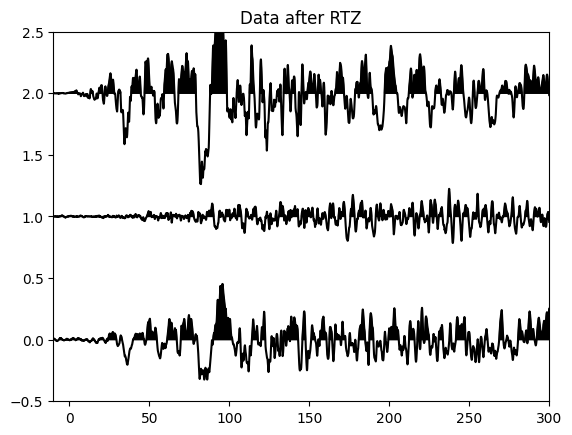

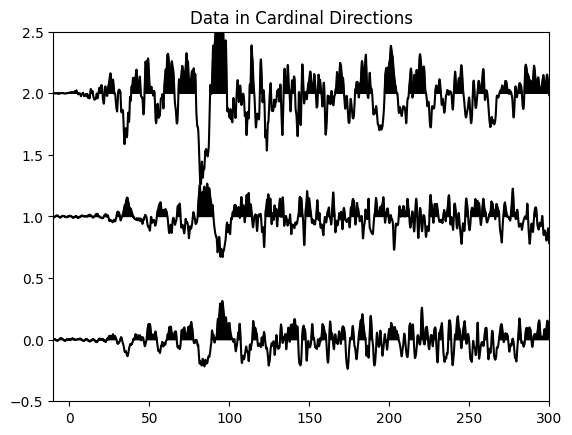

In [9]:
from mspasspy.algorithms.window import WindowData,scale
from mspasspy.algorithms.basic import ator
from mspasspy.graphics import SeismicPlotter
import matplotlib.pyplot as plt

# to reduce clutter we just only show one Seismogram
d0 = Seismogram(ens0.member[0])   # copy is safer
d = Seismogram(ensemble.member[0])
Ptime = d['Ptime']
d0.ator(Ptime)
d.ator(Ptime)
# relative window times
ts = -10.0
te = 300.0
d=WindowData(d,ts,te)
d0.rotate_to_standard()
d0=WindowData(d0,ts,te)
# scale applied to 3c data scales components equally
d=scale(d)
d0=scale(d0)
plotter = SeismicPlotter(scale=0.25,title='Data after RTZ')
plt0 = SeismicPlotter(scale=0.25,title='Data in Cardinal Directions')
# the default will be a bit ugly for this case 
plotter.change_style('wtva')
plt0.change_style('wtva')
plotter.plot(d)
plt.show()
plt0.plot(d0)
plt.show()



Note for transformed data the components are arranged from the bottom up so 0 is R, 1 is T, and 2 is Z.   For the original data drawn for reference 0 is EW, 1 is NS, and 2 is Z.  You can see this transformation does not alter Z at all and drastically reduces the amplitude on T since this window is focused o the P phae. 

### LQT Transformation
The next most common transformation for P wave data is commonly called LQT; L-longitudinal, Q radial rotated away from vertical, and T for transverse. (For a good discussion of the details see [https://refubium.fu-berlin.de/bitstream/handle/fub188/1036/05_chapter3.pdf?sequence=6] ).  The same rotate function we used above is "overloaded" and can be used to produce a (right handed) variant of LQT that is probably more appropriately called TQL.   That is, the code below will transform the data so x1->T (transverse==SH), x2->Q (radial--SV), and x3->L (longitudinal==P).   As before we first show the example and defer discussion of how it works to the box following the code.

In [10]:
from obspy.taup import TauPyModel
from mspasspy.ccore.utility import SphericalCoordinate

ttmodel = TauPyModel(model="iasp91")
# Free surface P velocity - need this to compute ema
vp0=6.0 
Rearth=6371.0  # rough earth radius - good enough here
# restore the original data we read from the db from the copy made 
# earlier - much faster
ensemble=SeismogramEnsemble(ens0)
print("station seaz rotation_angle emergence_angle")
for i in range(len(ensemble.member)):
    d = ensemble.member[i]   # d is a shorthand symbol used for clarity
    # this Metadata attribute was computed and saved in the getting_started 
    # tutorial.  seaz is css3.0 shorthand for "station to event azimuth"
    # also commonly called "back azimuth".  See below for why
    # we compute az and theta
    seaz = d['seaz']
    az = seaz + 180.0
    # not essential but make result more understandable
    # computing azimuth difference to rotate X1 (EW) axis
    if az>360.0:
        az -= 360.0
    # TODO: there is a sign convention mismatch that needs to be fixed here
    # this operation uses spherical coordinate angle phi
    phi = 90.0-az
    # we didn't save the slowness of the P phase so we need to compute it 
    # with obspy's travel time calculator
    dist = d['epicentral_distance']  # also set by getting_started
    depth = d['source_depth']
    arrivals=ttmodel.get_travel_times(source_depth_in_km=depth,
                                            distance_in_degree=dist,
                                            phase_list=['P'])
    rayp = arrivals[0].ray_param
    # rayp has units of seconds/degree and is p in p=r sin(theta)/v
    # solve for theta which we will call ema (emergence angle)
    ema = np.arcsin(rayp*vp0/Rearth)
    # Don't print all of these as they do not vary that much
    if i<10:
        print(d['sta'],seaz,phi,np.degrees(ema))
    sc = SphericalCoordinate()
    sc.phi=np.radians(phi)
    # np.arcsin returns angle in radians needed here so no conversion needed
    sc.theta=ema   
    # We use the function form of this method here
    d = rotate_to_standard(d)
    d = rotate(d,sc)
    # An oddity of python is this is needed to update the ensemble
    ensemble.member[i]=d

station seaz rotation_angle emergence_angle
Z38A 318.58697171197156 -48.58697171197156 14.475558178889493
Z39A 319.03610289699213 -49.03610289699213 14.458027846122912
Z40A 319.47822388143476 -49.47822388143476 14.43915478526362


I recommend you compare the code box above to that above for computing the RTZ transform.   Some key differences are:
1.  We need to compute the emergence angle for the P wave.  We need that because LQT defines the longitudinal to be the vector pointing in the direction expected for an isotropic earth with a surface velocity we define here with the constant `vp0`.   It should be obvious that is a gross approximation, but a (theoretical) improvement over RTZ for component separation into the concept of P, SV, and SH.   We use the standard Snell's law formula to compute that angle stored with the symbol `ema`.
2.  In MsPASS the LQT transform is implemented with a `SphericalCoordinate` object that is a simple data structure with the standard "phi" and "theta" angles. An implementation detail is that both need to be specified in radians.  The direction defined is the upward pointing vector that will define the L direction after the transformation.  Internally the code sorts out Q and T to produce a right-handed system with the (nonstandard) order TQL.  (The more common standard is LQT order).
3.  We use the `rotate` function but in this case instead of just an number defining an angle we pass the `SphericalCoordinate` object we set above when we call to the `rotate` function.   In computer jargon "rotate is overloaded" and accepts either type for arg1.

With that understand let's plot an example of what we just created.

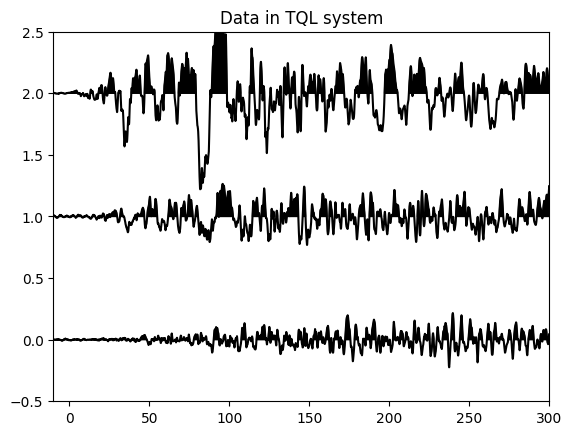

In [11]:
# to reduce clutter we just only show one Seismogram
d = Seismogram(ensemble.member[0])
Ptime = d['Ptime']
d.ator(Ptime)
# relative window times
ts = -10.0
te = 300.0
d=WindowData(d,ts,te)
# scale applied to 3c data scales components equally
d=scale(d)
plotter = SeismicPlotter(scale=0.25,title='Data in TQL system')
# the default will be a bit ugly for this case 
plotter.change_style('wtva')
plotter.plot(d)
plt.show()



Graphically this looks very similar to the RTZ output other than the order being different.  (There is also a sign difference in T to keep the coordinates right handed, but that is a detail.)  

### Free surface transformation
The most sophisticated coordinate transformation for P wave data is a special operator commonly called the "free surface transformation".  The theory for the matrix transformation is in Brian Kennett's (1983) book on layered media theory.  The operator requires a bit more information than rotation to RTZ or LQT.  This is most easily seen by an example again deferring the discussion to after the box showing the example:

In [13]:
import math
from mspasspy.ccore.seismic import SlownessVector

# Again restore the original from the copy for speed
ensemble = SeismogramEnsemble(ens0) 

# Free surface P and S velocitites
vp0=6.0  
vs0=3.5
for d in ensemble.member:
    # this Metadata attribute was computed and saved in the getting_started 
    # tutorial.  seaz is css3.0 shorthand for "station to event azimuth"
    # also commonly called "back azimuth"
    seaz = d['seaz']
    # we didn't save the slowness of the P phase so we need to compute it 
    # with obspy's travel time calculator
    dist = d['epicentral_distance']  # also set by getting_started
    depth = d['source_depth']
    arrivals=ttmodel.get_travel_times(source_depth_in_km=depth,
                                            distance_in_degree=dist,
                                            phase_list=['P'])
    rayp = arrivals[0].ray_param
    # Some basic seismology here.  rayp is the spherical earth ray parameter
    # R sin(theta)/v.  We need sin(theta)/v which is 1/v0 where v0 is the 
    # apparent velocity of the phase at Earth's surface.  Simple conversion
    # with equitorial radius of the earth, Re.  
    Re=6378.1
    rayp /= Re
    # Free surface tranformation requires us to convert that to a 
    # slowness vector.  That defines both the direction and magnitude of 
    # near surface phase velocity (slowness).  A complication is that 
    # SlownessVector needs propagation direction not back azimuth so 
    # we need to first compute azimuth 
    az = seaz + 180.0 
    ux = rayp * math.sin(az)  # cartesian x but azimuth is from y (north)
    uy = rayp *math.cos(az)
    u = SlownessVector(ux,uy)
    d.free_surface_transformation(u,vp0,vs0)    

Let's see what that did by looking first at the transformation matrices.

In [14]:
for i in range(len(ensemble.member)):
    print("Member number ",i," tranformation matrix after fst")
    print(ensemble.member[i].tmatrix)
    print('Value returned by orthogonal method=',ensemble.member[i].orthogonal())

Member number  0  tranformation matrix after fst
[[-0.30041384 -0.39968928  0.        ]
 [ 0.38685639 -0.2907684   0.08496352]
 [-0.11643089  0.08751161  0.49444659]]
Value returned by orthogonal method= False
Member number  1  tranformation matrix after fst
[[-0.44415851 -0.22961537  0.        ]
 [ 0.22226069 -0.42993192  0.08486282]
 [-0.06680849  0.12923158  0.49445955]]
Value returned by orthogonal method= False
Member number  2  tranformation matrix after fst
[[-0.49969364 -0.01750044  0.        ]
 [ 0.01694134 -0.48372947  0.0847544 ]
 [-0.00508539  0.14520424  0.49447349]]
Value returned by orthogonal method= False


If you looked at those matrices carefully you will find the basis vectors of the transformation matrices are not "orthogonal".   The secondary print of the output of the `orthogonal` method confirms that.   If you look closely you will find that T is orthogonal to both Q and L (the reason for the zeero in the (1,3) component of the matrix) but Q and L are not orthogonal.  The difference is not large, but theory and practice confirms this operator is about the best we can do to separate P and SV energy at a single station.   

With that in mind, here is the final plot.  You can compare this to the similar plots for the RTZ and LQT (TQL) transformations.   Note the order of the outputs of this transformation from the bottom up are SH, SV, P.

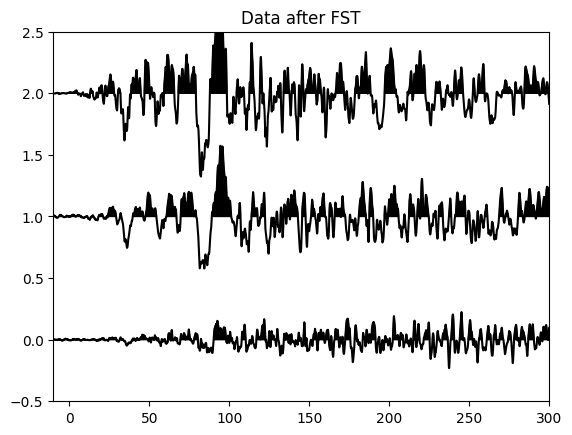

In [15]:
# to reduce clutter we just only show one Seismogram
d = Seismogram(ensemble.member[0])
Ptime = d['Ptime']
d.ator(Ptime)
# relative window times
ts = -10.0
te = 300.0
d=WindowData(d,ts,te)
# scale applied to 3c data scales components equally
d=scale(d)
plotter = SeismicPlotter(scale=0.25,title='Data after FST')
# the default will be a bit ugly for this case 
plotter.change_style('wtva')
plotter.plot(d)
plt.show()

